#14757 Homework 6 (150 pts)

## **Due:** Wednesday December 4 at 3pm ET / 12 noon PT

## Submission Instructions

*   Download your completed notebook by clicking File->Download .ipynb and submit it on Gradescope
*   Check your submission on Gradescope to make sure that all your code, code output and written responses appear correctly

## Problem 1: Gradescope Autograder Placeholder (0 pts)

Gradescope requires that problem 1 be autograded for code submissions, but there are no autograded problems. Continue to problem 2.

## Problem 2: Image Segmentation Using Expectation-Maximization (75 pts)

In this problem you will implement and compare a few  ways of segmenting an image based on color.

Run the cell below to load an [image of a colorful flower](http://www.andrew.cmu.edu/user/dvaroday/14757/data/hw6/strelitzia.jpg), and also run $k$-means clustering on the pixels with 3 different values for number of clusters.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from urllib.request import urlopen
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

# Load image
url = 'http://www.andrew.cmu.edu/user/dvaroday/14757/data/hw6/strelitzia.jpg'
img = np.array(plt.imread(urlopen(url), 0), dtype=float)/255

# Reshape image data into 2-D array
w, h, d = img.shape
img_array = img.reshape(w*h, d)

# Run k-means on the pixels with 3 different values for number of clusters
num_clusters = [2, 5, 10]
kmeans_list = []
for i in range(len(num_clusters)):
  kmeans = KMeans(n_clusters=num_clusters[i], n_init='auto')
  kmeans.fit_predict(img_array)
  kmeans_list.append(kmeans)

**2.1** (20 pts) Complete the function `reconstruct_image()` in the cell below so that it returns the image with each pixel replaced by its cluster center. The cell will display the 3 segmentations from the $k$-means clustering.

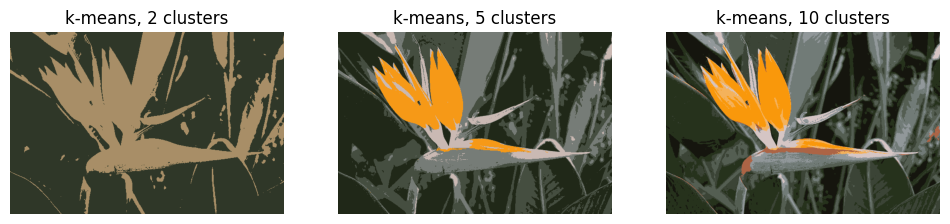

In [4]:
# Reconstruct the image by replacing each pixel by its cluster center
def reconstruct_image(centers, labels, w, h, d):
    image = np.zeros((w, h, d))

    # START EDITING HERE - DON'T REMOVE THIS COMMENT
    image = centers[labels].reshape((w, h, d))
    # END EDITING HERE - DON'T REMOVE THIS COMMENT

    return image

# Display reconstructed images
fig = plt.figure(figsize=(12, 12))
axarr = fig.subplots(1, len(num_clusters))
for i in range(len(num_clusters)):
  axarr[i].imshow(reconstruct_image(kmeans_list[i].cluster_centers_,
                                    kmeans_list[i].labels_, w, h, d))
  axarr[i].set_title('k-means, ' + str(num_clusters[i]) + ' clusters')
  axarr[i].axis('off')

**2.2** (40 pts) In the `EM` class below complete the methods `__init__()`, `e_step()`, `m_step()` and `set_labels()` to implement color segmentation using the EM algorithm. In particular you should edit the constructor `__init__()` so that it initializes the algorithm with the clustering provided by the `kmeans` argument. Use `multivariate_normal.pdf()` to implement the calculation in `e_step()` and as a consequence make it numerically stable: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

The segmentation images you obtain in this part of the problem should be very similar to the ones obtained from $k$-means only. But if you look carefully you should be able to find differences in the colors and pixel assignments of the clusters, especially in the case of 10 clusters.



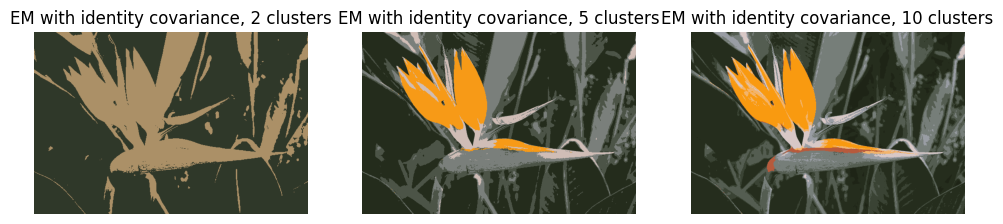

In [ ]:
# START EDITING HERE - DON'T REMOVE THIS COMMENT
class EM:

  # Constructs EM object
  def __init__(self, img_array, kmeans, cov, num_iters=10):
    self.img_array = img_array
    self.cov = cov
    self.num_iters = num_iters

    # Initializing the EM object to the clustering passed in as kmeans
    self.num_clusters = kmeans.cluster_centers_.shape[0]
    self.means = kmeans.cluster_centers_.copy()  # K x 3
    self.labels = kmeans.labels_.copy()  # N
    N = img_array.shape[0]

    # Compute initial mixing weights from cluster assignments
    counts = np.bincount(self.labels, minlength=self.num_clusters)
    self.mix_weights = counts / N

    # Initialize the responsibilities (weights) matrix
    # weights will be (K, N), each column corresponds to a pixel
    # Initially, based on the kmeans labels, assign 1 to the chosen cluster and 0 otherwise
    self.weights = np.zeros((self.num_clusters, N))
    self.weights[self.labels, np.arange(N)] = 1.0
    
  # Updates weight matrix
  # Hint: use multivariate_normal.pdf() to implement part of the calculation
  def e_step(self):
    N = self.img_array.shape[0]

    # Compute unnormalized responsibilities
    pdf_vals = np.zeros((self.num_clusters, N))
    for k in range(self.num_clusters):
      # Evaluate pdf for cluster k
      pdf_vals[k, :] = multivariate_normal.pdf(
          self.img_array, mean=self.means[k], cov=self.cov
      )
    # Multiply by mixing weights
    pdf_vals *= self.mix_weights[:, np.newaxis]

    # Normalize to get responsibilities
    sum_over_k = np.sum(pdf_vals, axis=0) + 1e-15  # add small constant for numerical stability
    self.weights = pdf_vals / sum_over_k

  # Updates means and mixing weights
  def m_step(self):
    N = self.img_array.shape[0]

    # Compute cluster-wise sums of responsibilities
    cluster_respons_sum = np.sum(self.weights, axis=1)  # K
    # Update means
    self.means = (self.weights @ self.img_array) / cluster_respons_sum[:, np.newaxis]
    # Update mixing weights
    self.mix_weights = cluster_respons_sum / N

  # Sets pixel labels after EM iterations are complete
  def set_labels(self):
    self.labels = np.argmax(self.weights, axis=0)

  # Performs image color segmentation
  def segment(self):
    for iter in range(self.num_iters):
      self.e_step()
      self.m_step()
    self.set_labels()
# END EDITING HERE - DON'T REMOVE THIS COMMENT


# Display reconstructed images
fig = plt.figure(figsize=(12, 12))
axarr = fig.subplots(1, len(num_clusters))
for i in range(len(num_clusters)):
  em = EM(img_array, kmeans=kmeans_list[i], cov=0.01*np.identity(3))
  em.segment()
  axarr[i].imshow(reconstruct_image(em.means, em.labels, w, h, d))
  axarr[i].set_title('EM with identity covariance, '
                     + str(num_clusters[i]) + ' clusters')
  axarr[i].axis('off')

**2.3** (5 pts) You obtained the segmentation images in the cell above by using the covariance matrix $\frac{1}{100}I$ for all clusters in the EM model. In the cell below replace $\frac{1}{100}I$ with the covariance of all the pixels in the original image. The resulting segmentation images should look quite different from the ones you have seen before.

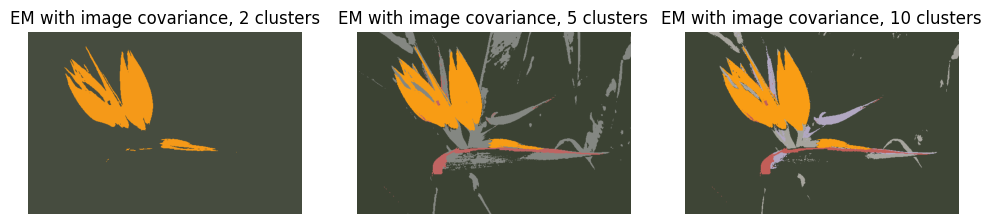

In [6]:
# Display reconstructed images
fig = plt.figure(figsize=(12, 12))
axarr = fig.subplots(1, len(num_clusters))
for i in range(len(num_clusters)):

  # EDIT THE LINE BELOW - DON'T REMOVE THIS COMMENT
  em = EM(img_array, kmeans=kmeans_list[i], cov=np.cov(img_array.T))

  em.segment()
  axarr[i].imshow(reconstruct_image(em.means, em.labels, w, h, d))
  axarr[i].set_title('EM with image covariance, '
                     + str(num_clusters[i]) + ' clusters')
  axarr[i].axis('off')

**2.4** (10 pts) Notice that setting the `cov` argument to the covariance of the original image results in cleaner background segmentations than using $\frac{1}{100}I$. In other words more of the background pixels end up in one background cluster. As a result the foreground clusters become smaller and more specific, and so are represented by more accurate colors. Explain in a paragraph why changing the covariance matrix in this way makes more of the background pixels end up in one background cluster.

WRITE YOUR ANSWER HERE:
When using the cov matrix from the entire image's true spread and correlation of colors, common large clusters like the background pixels fit well into a single large cluster rather than being split. However, this does effectively "paint over" some of the smaller background paint splashes or strokes of thinner but detail-oriented pixels that would otherwise offer contrast to the background. 


## Problem 3: Search Engine Optimization (75 pts)

In this problem you will explore a web graph that was scraped from the web some time during the early years of Google. You will consider how Yahoo might have attacked Google's PageRank algorithm to elevate the Yahoo homepage in Google search results and how Google may have reacted.

The nodes of the web graph are URLs associated with the search term `California`. The edges denote links from one URL to another.

Run the cell below to load the URLs and links into data frames called `nodes` and `edges`, respectively.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sknetwork.ranking import PageRank
from warnings import filterwarnings

# Load node (URL) and edge (link) data
url = 'https://www.cs.cornell.edu/courses/cs685/2002fa/data/gr0.California'

num_nodes = 9664
edges = pd.read_table(url, sep='\s', header=None, skiprows=num_nodes,
                   usecols=[1, 2], names=['from', 'to'], engine='python')
num_edges = len(edges)
nodes = pd.read_table(url, sep='\s', header=None, skipfooter=num_edges,
                   usecols=[1, 2], names=['idx', 'url'], engine='python')

display(nodes)
display(edges)

,idx,url
0,0,http://www.berkeley.edu/
1,1,http://www.caltech.edu/
2,2,http://www.realestatenet.com/
3,3,http://www.ucsb.edu/
4,4,http://www.washingtonpost.com/wp-srv/national/...
...,...,...
9659,9659,http://www.spd.louisville.edu/~mejenn01/handy....
9660,9660,http://www.maxwellstreet.org/
9661,9661,http://village.ios.com/~internet/
9662,9662,http://www.meats.net/


,from,to
0,0,449
1,0,450
2,0,451
3,0,452
4,0,453
...,...,...
16145,9663,1806
16146,9663,266
16147,9663,7905
16148,9663,70


Lets estimate the year in which this data set was scraped. Run the cell below to plot the number of occurences of the strings "1994" through "2004" in the data set's URLs.

*Yahoo was founded in 1994 and incorporated in 1995. Google began as a research project in 1996, it registered its domain in 1997 and incorporated in 1998. Also in 1998 Yahoo turned down an opportunity to buy Google for \$1 million. In 2002 Yahoo made a \$3 billion offer to buy Google but this time Google turned down the offer. Yahoo Search was actually powered by Google for a few years until 2004.*



<BarContainer object of 11 artists>

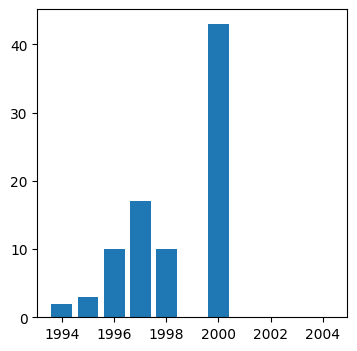

In [3]:
years = range(1994,2005)
counts = []
for year in years:
  counts.append(nodes['url'].str.contains(str(year)).sum())

plt.figure(figsize = (4,4))
plt.bar(years, counts)

**3.1** (5 pts) In which year was this data set scraped from the web? If you are not sure, take a look at the URLs that contain the year strings.

WRITE YOUR ANSWER HERE:
As there is not data after the year 2000, I will assume the data was scraped in the year 2000.

In the cell below, the edge list is converted into an adjacency matrix. The $(i, j)$ entry of `adjacency` is $1$ if there is a link from the $i$th URL to the $j$th URL; and $0$ otherwise. We use a sparse matrix representation for `adjacency` because it is mostly zeroes.

**3.2** (10 pts) Complete the function `search_rank()` in the cell below. The function should return the positive integer rank of `target_url` when the PageRank algorithm is applied to `adj_matrix`. In other words, `search_rank(yahoo_home_url, adjacency)` should return position of the Yahoo homepage in the list of results for the search on `California`; for example, it would return $1$ if the Yahoo homepage were the top ranking URL.



In [4]:
# Suppress warnings about changing the sparsity structure of csr_matrix
filterwarnings("ignore", message="Changing the jsparsity structure.*")

# Convert edge list to adjacency matrix (sparse representation)
adjacency = csr_matrix((np.ones(len(edges)), (edges['from'], edges['to'])),
                       shape=(num_nodes, num_nodes), dtype=int)

def search_rank(target_url, adj_matrix):
  pagerank = PageRank()
  stationary_distribution = pagerank.fit_predict(adj_matrix)

  # START EDITING HERE - DON'T REMOVE THIS COMMENT
  # Get the index of the target_url
  target_idx = nodes.loc[nodes['url'] == target_url, 'idx'].values[0]

  # Sort pages by PageRank score in descending order
  sorted_indices = np.argsort(-stationary_distribution)

  # Find the rank of the target_idx (1-based)
  rank = np.where(sorted_indices == target_idx)[0][0] + 1
  # END EDITING HERE - DON'T REMOVE THIS COMMENT

  return rank

yahoo_home_url = "http://www.yahoo.com/"
print('Yahoo homepage search rank:', search_rank(yahoo_home_url, adjacency))

Yahoo homepage search rank: 22


**3.3** (10 pts) Suppose Yahoo attempts to improve the search ranking of its homepage by increasing its number of backlinks. Specifically Yahoo adds links that point to its homepage from all the **other** pages it controls. There are in total 222 pages controlled by Yahoo (besides the homepage itself) including ones in the domains `yahoo.com`, `yahoo.co.uk`, `yahoo.ie`, etc. Edit `adj_backlinks` in the cell below to simulate this attack and print out the new search rank for the Yahoo homepage.

In [5]:
adj_backlinks = adjacency.copy()

# START EDITING HERE - DON'T REMOVE THIS COMMENT
# Identify the index of the Yahoo homepage
target_idx = nodes.loc[nodes['url'] == yahoo_home_url, 'idx'].values[0]

# Identify all Yahoo-controlled pages (excluding the homepage)
yahoo_pages = nodes[(nodes['url'].str.contains('yahoo')) & (nodes['url'] != yahoo_home_url)]

# Add backlinks from these Yahoo-controlled pages to the Yahoo homepage
for src_idx in yahoo_pages['idx'].values:
    adj_backlinks[src_idx, target_idx] = 1

# END EDITING HERE - DON'T REMOVE THIS COMMENT

print('Yahoo homepage search rank with more backlinks:',
      search_rank(yahoo_home_url, adj_backlinks))

Yahoo homepage search rank with more backlinks: 6


/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-Sq82vzHy-py3.10/lib/python3.10/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


**3.4** (10 pts) The addition of the backlinks went undetected by Google, so Yahoo decides to improve its homepage's search ranking even further using a link sculpting approach. Yahoo engineers figure out a way to [obfuscate links](https://www.drupal.org/project/link_obfuscator) so that they work normally for human users but become invisible to robots. Edit `adj_sculpting` in the cell below to improve the Yahoo homepage's search rank as much as possible by applying link sculpting to all 222 pages that Yahoo controls (besides the homepage itself.)

In [6]:
adj_sculpting = adj_backlinks.copy()

# START EDITING HERE - DON'T REMOVE THIS COMMENT
# Identify the index of the Yahoo homepage
target_idx = nodes.loc[nodes['url'] == yahoo_home_url, 'idx'].values[0]

# Identify all Yahoo-controlled pages (excluding the homepage)
yahoo_pages = nodes[(nodes['url'].str.contains('yahoo')) & (nodes['url'] != yahoo_home_url)]

# Link sculpting: Remove all outbound links from these Yahoo-controlled pages
# except the one to the Yahoo homepage.
for src_idx in yahoo_pages['idx'].values:
    # Set all outbound links to 0
    adj_sculpting.data[adj_sculpting.indptr[src_idx]:adj_sculpting.indptr[src_idx+1]] = 0
    # Now explicitly set only the link to homepage
    adj_sculpting[src_idx, :] = 0
    adj_sculpting[src_idx, target_idx] = 1
# END EDITING HERE - DON'T REMOVE THIS COMMENT

print('Yahoo homepage search rank with link sculpting:',
      search_rank(yahoo_home_url, adj_sculpting))

/home/jrob/.cache/pypoetry/virtualenvs/py3-10-ml-env-Sq82vzHy-py3.10/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Yahoo homepage search rank with link sculpting: 3


**3.5** (10 pts) Now Google discovers and reverse engineers the link obfuscation. Not only does Google set its robot to follow all the human-clickable links, but it imposes an additional penalty on Yahoo: any links from Yahoo webpages to the Yahoo homepage will be ignored in the PageRank algorithm. Edit `adj_penalty` in the cell below to print out the Yahoo homepage's search ranking after the changes to Google's algorithms.

In [7]:
adj_penalty = adj_sculpting.copy()

# START EDITING HERE - DON'T REMOVE THIS COMMENT
# Identify the index of the Yahoo homepage
target_idx = nodes.loc[nodes['url'] == yahoo_home_url, 'idx'].values[0]

# Identify all Yahoo-controlled pages (excluding the homepage)
yahoo_pages = nodes[(nodes['url'].str.contains('yahoo')) & (nodes['url'] != yahoo_home_url)]

# Set all links from Yahoo-controlled pages to the Yahoo homepage to zero
for src_idx in yahoo_pages['idx'].values:
    adj_penalty[src_idx, target_idx] = 0
# END EDITING HERE - DON'T REMOVE THIS COMMENT

print('Yahoo homepage search rank after Google penalty:',
      search_rank(yahoo_home_url, adj_penalty))

Yahoo homepage search rank after Google penalty: 33


**3.6** (10 pts) Why is the Yahoo homepage's search ranking worse after Google's penalty than in the beginning? Use 1-2 sentences in your answer.

WRITE YOUR ANSWER HERE:
Googles penalty added to Yahoo ignores Yahoo's self-curated backlinks to the Yahoo homepage. 

**3.7** (5 pts) After dropping in the search ranking, some Yahoo executives decide to make one more effort. They purchase a link to the Yahoo homepage from the homepage of the promisingly-named startup LinkExchange. Edit `adj_buy_link` in the cell below to print out the Yahoo homepage's search ranking after a link to it is added on the LinkExchange homepage.

In [8]:
link_exch_home_url = "http://www.linkexchange.com/"
adj_buy_link = adj_penalty.copy()

# START EDITING HERE - DON'T REMOVE THIS COMMENT
# Find indices of LinkExchange homepage and Yahoo homepage
link_exch_home_idx = nodes.loc[nodes['url'] == link_exch_home_url, 'idx'].values[0]
yahoo_home_idx = nodes.loc[nodes['url'] == yahoo_home_url, 'idx'].values[0]

# Add a link from LinkExchange homepage to Yahoo homepage
adj_buy_link[link_exch_home_idx, yahoo_home_idx] = 1
# END EDITING HERE - DON'T REMOVE THIS COMMENT

print('Yahoo homepage search rank after buying link:',
      search_rank(yahoo_home_url, adj_buy_link))

Yahoo homepage search rank after buying link: 10


**3.8** (5 pts) A Yahoo engineer suggests that it would be helpful for the Yahoo homepage to link back to the LinkExchange homepage. Edit `adj_link_back` in the cell below to print out the Yahoo homepage's search ranking after it links back to the LinkExchange homepage.

In [9]:
adj_link_back = adj_buy_link.copy()

# START EDITING HERE - DON'T REMOVE THIS COMMENT
# Find indices of LinkExchange homepage and Yahoo homepage
link_exch_home_idx = nodes.loc[nodes['url'] == link_exch_home_url, 'idx'].values[0]
yahoo_home_idx = nodes.loc[nodes['url'] == yahoo_home_url, 'idx'].values[0]

# Add a link from the Yahoo homepage back to the LinkExchange homepage
adj_link_back[yahoo_home_idx, link_exch_home_idx] = 1
# END EDITING HERE - DON'T REMOVE THIS COMMENT

print('Yahoo homepage search rank after linking back:',
      search_rank(yahoo_home_url, adj_link_back))

Yahoo homepage search rank after linking back: 1


**3.9** (10 pts) Why does linking back to the LinkExchange homepage improve the Yahoo homepage's search ranking? Use 1-2 sentences in your answer.

WRITE YOUR ANSWER HERE:
Yahoo found another way around the algorithm. It basically enabled the crawler to execute a cyclical backlink in a closed loop, thus, greatly improving Yahoo's ranking